In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

In [2]:
from pandas import read_hdf
final_train = read_hdf('storage_sample_stage4.h5', 'train_df',mode='r')
final_test = read_hdf('storage_sample_stage4.h5', 'test_df',mode='r')

In [3]:
if os.path.isfile('train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


In [4]:
final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [5]:
train = final_train[['source_node','destination_node']]
test = final_test[['source_node','destination_node']]

In [6]:
train.shape

(100002, 2)

In [7]:
train.iloc[4]

source_node          140165
destination_node    1708748
Name: 4, dtype: int64

In [8]:
train_nodes = []
for i in range(len(train)):
    train_nodes.append(tuple(train.iloc[i]))

test_nodes = []
for j in range(len(test)):
    test_nodes.append(tuple(test.iloc[j]))

In [10]:
pref_indegree_train = []

for node in tqdm(train_nodes):
    try:
        pref_indegree_train.append(train_graph.in_degree(node[0])*train_graph.in_degree(node[1]))
    except:
        pref_indegree_train.append(0)

100%|██████████████████████████████████████████████████████████████████████| 100002/100002 [00:00<00:00, 211093.40it/s]


In [13]:
pref_indegree_test = []

for node in tqdm(test_nodes):
    try:
        pref_indegree_test.append(train_graph.in_degree(node[0])*train_graph.in_degree(node[1]))
    except:
        pref_indegree_test.append(0)

100%|████████████████████████████████████████████████████████████████████████| 50002/50002 [00:00<00:00, 224825.57it/s]


In [14]:
pref_outdegree_train = []

for node in tqdm(train_nodes):
    try:
        pref_outdegree_train.append(train_graph.out_degree(node[0])*train_graph.out_degree(node[1]))
    except:
        pref_outdegree_train.append(0)

100%|██████████████████████████████████████████████████████████████████████| 100002/100002 [00:00<00:00, 258425.81it/s]


In [15]:
pref_outdegree_test = []

for node in tqdm(test_nodes):
    try:
        pref_outdegree_test.append(train_graph.out_degree(node[0])*train_graph.out_degree(node[1]))
    except:
        pref_outdegree_test.append(0)

100%|████████████████████████████████████████████████████████████████████████| 50002/50002 [00:00<00:00, 244529.99it/s]


In [16]:
final_train['pref_score_indegree'] = pref_indegree_train
final_test['pref_score_indegree'] = pref_indegree_test
final_train['pref_score_outdegree'] = pref_outdegree_train
final_test['pref_score_outdegree'] = pref_outdegree_test

In [17]:
hdf = HDFStore('storage_sample_stage5.h5')
hdf.put('train_df',final_train, format='table', data_columns=True)
hdf.put('test_df',final_test, format='table', data_columns=True)
hdf.close()

In [19]:
final_train['svd_dot_u'] = (final_train['svd_u_s_1']*final_train['svd_u_d_1']) +\
                                (final_train['svd_u_s_2']*final_train['svd_u_d_2']) + \
                                (final_train['svd_u_s_3']*final_train['svd_u_d_3']) + \
                                (final_train['svd_u_s_4']*final_train['svd_u_d_4']) + \
                                (final_train['svd_u_s_5']*final_train['svd_u_d_5']) + \
                                (final_train['svd_u_s_6']*final_train['svd_u_d_6'])

final_test['svd_dot_u'] = (final_test['svd_u_s_1']*final_test['svd_u_d_1']) +\
                                (final_test['svd_u_s_2']*final_test['svd_u_d_2']) + \
                                (final_test['svd_u_s_3']*final_test['svd_u_d_3']) + \
                                (final_test['svd_u_s_4']*final_test['svd_u_d_4']) + \
                                (final_test['svd_u_s_5']*final_test['svd_u_d_5']) + \
                                (final_test['svd_u_s_6']*final_test['svd_u_d_6'])

final_train['svd_dot_v'] = (final_train['svd_v_s_1']*final_train['svd_v_d_1']) +\
                                (final_train['svd_v_s_2']*final_train['svd_v_d_2']) + \
                                (final_train['svd_v_s_3']*final_train['svd_v_d_3']) + \
                                (final_train['svd_v_s_4']*final_train['svd_v_d_4']) + \
                                (final_train['svd_v_s_5']*final_train['svd_v_d_5']) + \
                                (final_train['svd_v_s_6']*final_train['svd_v_d_6'])

final_test['svd_dot_v'] = (final_test['svd_v_s_1']*final_test['svd_v_d_1']) +\
                                (final_test['svd_v_s_2']*final_test['svd_v_d_2']) + \
                                (final_test['svd_v_s_3']*final_test['svd_v_d_3']) + \
                                (final_test['svd_v_s_4']*final_test['svd_v_d_4']) + \
                                (final_test['svd_v_s_5']*final_test['svd_v_d_5']) + \
                                (final_test['svd_v_s_6']*final_test['svd_v_d_6'])

In [20]:
hdf = HDFStore('storage_sample_stage6.h5')
hdf.put('train_df',final_train, format='table', data_columns=True)
hdf.put('test_df',final_test, format='table', data_columns=True)
hdf.close()

In [21]:
final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'pref_score_indegree', 'pref_score_outdegree', 'svd_dot_u',
       'svd_dot_v'],
      dtype='object')

In [22]:
y_train = final_train.indicator_link
y_test = final_test.indicator_link

In [23]:
final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [24]:
y_train.value_counts()

1    50050
0    49952
Name: indicator_link, dtype: int64

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
x_cfl=XGBClassifier(nthread=-1)

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[10,100,300,500,1000],
     'max_depth':[3,5,10,15,20],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,cv=5,verbose=10,return_train_score=True,n_jobs=-1)
random_cfl.fit(final_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed: 29.4min remaining:  6.5min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 43.0min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 43.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n...
                                           validate_parameters=None,
                                           verbosity=None),
                   iid='deprecated', n_iter=10, n_j

In [26]:
random_cfl.best_params_

{'subsample': 0.5,
 'n_estimators': 1000,
 'max_depth': 5,
 'learning_rate': 0.03,
 'colsample_bytree': 1}

In [29]:
cfl=XGBClassifier(n_estimators=1000,max_depth=5,learning_rate=0.03,colsample_bytree=1,subsample=0.5,nthread=-1)
cfl.fit(final_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
y_train_pred = cfl.predict(final_train)
y_test_pred = cfl.predict(final_test)

In [31]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9915969757134548
Test f1 score 0.9224562976243836


In [32]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


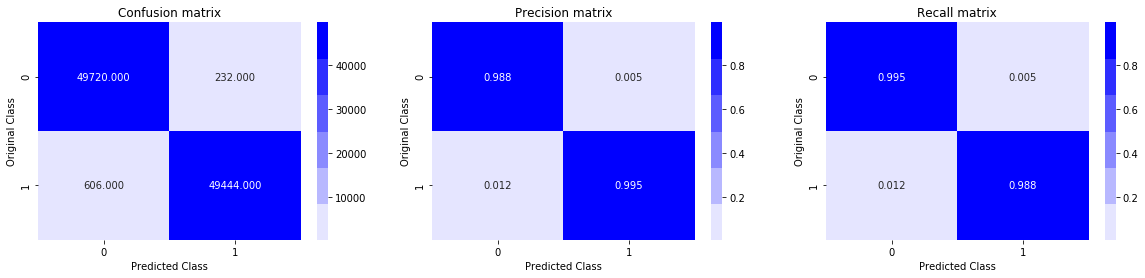

Test confusion_matrix


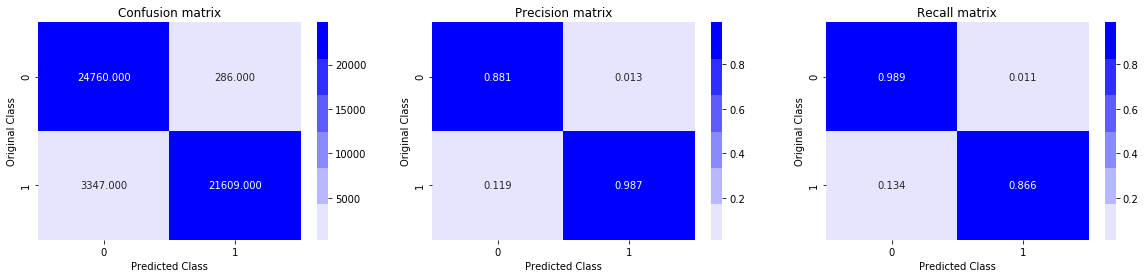

In [33]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

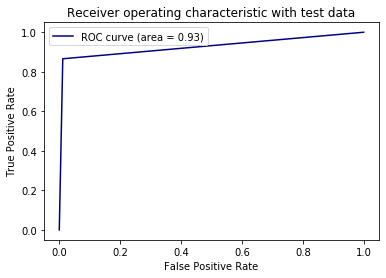

In [34]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

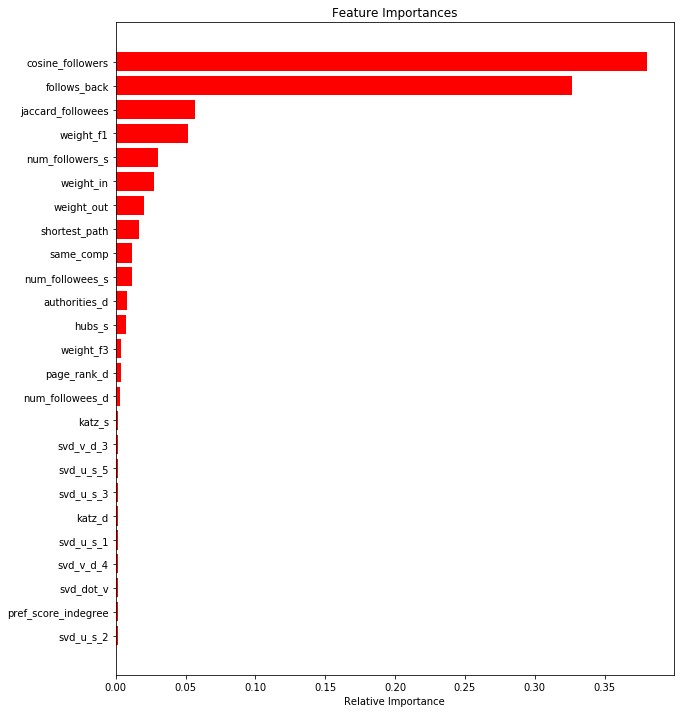

In [36]:
features = final_train.columns
importances = cfl.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

<li> Here we add features preferential attachment score and svd dot to the existing features</li>
<li> We build a model with the new features and took out the important features</li>
<li> It seems that svd_dot_v and pref_score_indegree have more importance than svd_dot_u and pref_score_outdegree features</li>